# Random Forests 

## Predicting Housing Prices

### Loading in Packages and Data

In [1]:
# https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import style
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
style.use('ggplot')

data_dir = '/Users/sam/Desktop/Portfolio Projects/Predicting Housing Prices/Data/'

# Data is from Kaggle: https://www.kaggle.com/c/house-prices-advanced-regression-techniques
train = pd.read_csv(data_dir + 'train.csv')
test = pd.read_csv(data_dir + 'test.csv')
sample = pd.read_csv(data_dir + 'sample_submission.csv')

### Cleaning Data

Some of the variables need to be encoded because they include strings. Then, to make splitting the train and test datasets easier later on I merge the sample and test datasets together.

In [2]:
def train_encode(x):
    train_vars = list(train.select_dtypes(include = ['category', 'object']))
    
    for i in train_vars:
        train[i] = train[i].astype('category').cat.codes
    return train

def test_encode(x):
    test_vars = list(test.select_dtypes(include=['category','object']))
    
    for i in test_vars:
        test[i] = test[i].astype('category').cat.codes
    return test

train = train_encode(train)
test = test_encode(test)

test = test.merge(sample, on = 'Id')

### Convert Data to Arrays and Split into Train and Test Datasets

The random forests algorithm inputs data through arrays. The label is the variable we are trying to predict (SalePrice). On the otherhand, features are all the other variables that the model uses to predict the label. We fill the remaining missing values with -1 because that's what the encoding did with the original string values.

In [3]:
train_features = train.iloc[: , :-1].fillna(-1)
train_feature_list = list(train_features.columns)
train_features = np.array(train_features)

test_features = test.iloc[: , :-1].fillna(-1)
test_feature_list = list(test_features.columns)
test_features = np.array(test_features)

train_labels = np.array(train['SalePrice'])
test_labels = np.array(test['SalePrice'])
test_actual = test[['Id', 'SalePrice']].rename(columns = {'SalePrice': 'Actual Value'})

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (1460, 80)
Training Labels Shape: (1460,)
Testing Features Shape: (1459, 80)
Testing Labels Shape: (1459,)


### Training the Model

In [4]:
rf = RandomForestRegressor(n_estimators = 2000, random_state = 1)

rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=2000, random_state=1)

### Predicting the Prices

In [5]:
predictions = rf.predict(test_features)
test_pred = pd.DataFrame(predictions).rename(columns = {0: 'Predicted Value'})

data = [test_actual, test_pred]

full = pd.concat(data)
full['Predicted Value'] = full['Predicted Value'].shift(-len(test_actual))
full = full.dropna()
full.to_csv(data_dir + 'RF_results.csv', index = None)

def mean_absolute_percentage_error(test_labels, predictions): 
    test_labels, predictions = np.array(test_labels), np.array(predictions)
    mape = np.mean(np.abs((test_labels - predictions) / test_labels)) * 100
    return mape

rmse = mean_squared_error(test_labels, predictions)**.5
mae = mean_absolute_error(test_labels, predictions)
mape = mean_absolute_percentage_error(test_labels, predictions)

accuracy = 100 - np.mean(mape)

print('RMSE: $', round(rmse, 2))
print('MAE: $', round(mae, 2))
print('Accuracy:', round(accuracy, 2), '%')

RMSE: $ 70137.06
MAE: $ 53751.23
Accuracy: 70.03 %


### Plotting Predicted vs. Actual Values

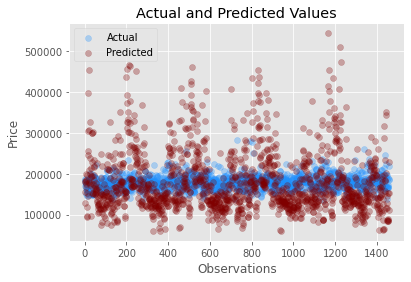

In [6]:
y_actual = full['Actual Value']
y_pred = full['Predicted Value']

fig, ax = plt.subplots()
ax.scatter(x = range(0, y_actual.size), y = y_actual, c = 'dodgerblue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred.size), y = y_pred, c = 'maroon', label = 'Predicted', alpha = 0.3)

plt.title('Actual and Predicted Values')
plt.xlabel('Observations')
plt.ylabel('Price')
plt.legend()
plt.show()

### Conclusion

On average, the random forests model was able to predict the sale price of a house within \\$53,751.

### Variable Importance

In [7]:
importances = list(rf.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(train_feature_list, 
                                                                                      importances)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:15} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: OverallQual     Importance: 0.58
Variable: GrLivArea       Importance: 0.11
Variable: TotalBsmtSF     Importance: 0.04
Variable: 2ndFlrSF        Importance: 0.04
Variable: BsmtFinSF1      Importance: 0.03
Variable: 1stFlrSF        Importance: 0.02
Variable: GarageCars      Importance: 0.02
Variable: LotFrontage     Importance: 0.01
Variable: LotArea         Importance: 0.01
Variable: Neighborhood    Importance: 0.01
Variable: YearBuilt       Importance: 0.01
Variable: YearRemodAdd    Importance: 0.01
Variable: MasVnrArea      Importance: 0.01
Variable: BsmtUnfSF       Importance: 0.01
Variable: FullBath        Importance: 0.01
Variable: TotRmsAbvGrd    Importance: 0.01
Variable: GarageYrBlt     Importance: 0.01
Variable: GarageArea      Importance: 0.01
Variable: Id              Importance: 0.0
Variable: MSSubClass      Importance: 0.0
Variable: MSZoning        Importance: 0.0
Variable: Street          Importance: 0.0
Variable: Alley           Importance: 0.0
Variable: LotSha

In [13]:
rf_most_important = RandomForestRegressor(n_estimators = 1000, random_state = 1)

# Extract Most Important
important_indicies = [test_feature_list.index('OverallQual'),
                     test_feature_list.index('GrLivArea'),
                     test_feature_list.index('TotalBsmtSF')]
train_important = train_features[:, important_indicies]
test_important = test_features[:, important_indicies]

# Train
rf_most_important.fit(train_important, train_labels)

# Make Predictions
predictions = rf_most_important.predict(test_important)

rmse = mean_squared_error(test_labels, predictions)**.5
mae = mean_absolute_error(test_labels, predictions)
mape = mean_absolute_percentage_error(test_labels, predictions)

accuracy = 100 - np.mean(mape)

print('RMSE: $', round(rmse, 2))
print('MAE: $', round(mae, 2))
print('Accuracy:', round(accuracy, 2), '%')

RMSE: $ 70699.8
MAE: $ 53143.53
Accuracy: 70.42 %
